In [ ]:
pip install pepit

In [5]:
from PEPit.point import Point
from PEPit.expression import Expression

def PD_proximal_step(x0,lambda0, f, g, alpha):

    
    # Define the output
    x1 = Point()
    lambda1 = Point()
    
    # subgradients of the two functions at the output points
    pf_x1 = (x0-x1)/alpha-lambda1
    pg_lambda1 = (lambda0-lambda1)/alpha+x1
    
    # function values
    fx1 = Expression()
    glambda1 = Expression()
    
    # associate the points, subgradient, and function values
    f.add_point((x1, pf_x1, fx1))
    g.add_point((pg_lambda1, lambda1, glambda1))

    # return: primal_output, dual_output, subgradient_of_f_at_primal_output, subgradient_of_g^*_at_primal_output
    return x1, lambda1, pf_x1, pg_lambda1

def evaluate_conjugate(lam,f):
    # this is just the Fenchel-Young equality
    x = Point()
    fx = Expression()
    f.add_point((x, lam, fx))
    fconj = lam*x - fx
    return fconj

In [7]:
# How many iteration?
n = 30

# Constant stepsize 1
alpha = n * [1]

# Verbose is ON
verbose = 1

In [8]:
### n iterations of primal-dual PPA

from PEPit import PEP
from PEPit.functions import ConvexFunction
from PEPit.functions import SmoothStronglyConvexFunction
from PEPit.primitive_steps import proximal_step
import numpy as np

problem = PEP()
    
f = problem.declare_function(ConvexFunction, reuse_gradient=True)
g = problem.declare_function(ConvexFunction, reuse_gradient=True)
F = f+g

# Start by defining its unique optimal point xs = x_* and corresponding function value fs = f_*
xs = F.stationary_point()
lambdas = -f.gradient(xs)

# Then define the starting point x0 of the algorithm
x0 = problem.set_initial_point()
lambda0 = problem.set_initial_point()

# Set the initial constraint that is the distance between x0 and x^*
problem.set_initial_condition((x0 - xs) ** 2 + (lambda0 - lambdas) ** 2 <= 1)

# Compute n steps of the proximal method starting from x0
x = list()
lam = list()
x.append(x0)
lam.append(lambda0)
current_x = x0
current_lam = lambda0
for i in range(n):
    previous_lam = current_lam
    previous_x = current_x
    current_x, current_lam, df_xk, dg_lambdak = PD_proximal_step(previous_x,previous_lam, f, g, alpha[i])
    x.append(current_x)
    lam.append(current_lam)

# Set the performance metric to the distance between x(n) and x(n-1)
problem.set_performance_metric((df_xk+current_lam) ** 2 + (current_x - dg_lambdak) ** 2)

# Solve the PEP
pepit_tau = problem.solve(verbose=verbose, dimension_reduction_heuristic="logdet2")

(PEPit) Setting up the problem: size of the Gram matrix: 64x64
(PEPit) Setting up the problem: performance measure is the minimum of 1 element(s)
(PEPit) Setting up the problem: Adding initial conditions and general constraints ...
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 2 function(s)
			Function 1 : Adding 930 scalar constraint(s) ...
			Function 1 : 930 scalar constraint(s) added
			Function 2 : Adding 930 scalar constraint(s) ...
			Function 2 : 930 scalar constraint(s) added
(PEPit) Setting up the problem: additional constraints for 0 function(s)
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: MOSEK); optimal value: 0.012471015365456306
(PEPit) Postprocessing: 6 eigenvalue(s) > 2.552493306421273e-06 before dimension reduction
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (solver: MOSEK); objective

In [9]:
## Subsample the non-zero coordinates (low rank solutions -> few coordinates)
index1 = 0
index2 = 1
coord1x = list()
coord2x = list()
coord1l = list()
coord2l = list()
for i in range(n+1):
    coord1x.append((x[i]-xs).eval()[index1])
    coord2x.append((x[i]-xs).eval()[index2])
    coord1l.append((lam[i]).eval()[index1])
    coord2l.append((lam[i]).eval()[index2])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


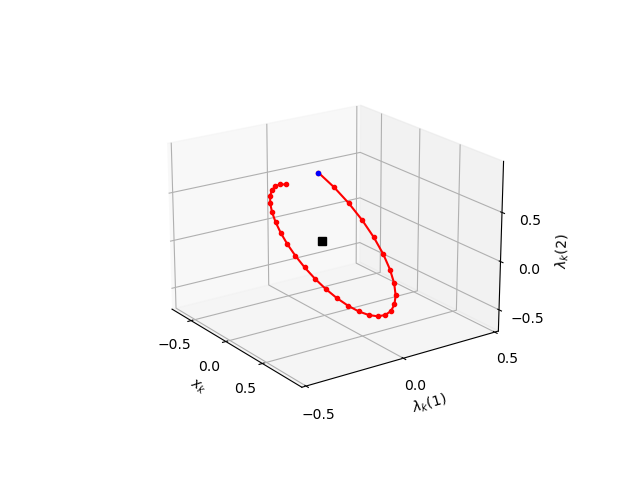

In [10]:
## Plot & save
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt


ax = plt.figure().add_subplot(projection='3d')
#plt.plot(coord1x, coord2x, '.-')
#plt.plot(coord1x[0], coord2x[0], 'ks')
#plt.plot(0, coord1l[0], coord2l[0], 'bs')

ax.plot(coord1x,coord1l, coord2l, 'r.-')
ax.plot(coord1x[0],coord1l[0], coord2l[0], 'b.')


ax.plot(0,lambdas.eval()[index1], lambdas.eval()[index2], 'ks')

#plt.xlabel('coord 1 (x)')
#plt.ylabel('coord 1 (l)')
#plt.zlabel('coord 1 (l)')

ax.set_xlabel('$x_k$')
ax.set_ylabel('$\lambda_k(1)$')
ax.set_zlabel('$\lambda_k(2)$')
ax.set_xticks([-.5,0,.5])
ax.set_yticks([-.5,0,.5])
ax.set_zticks([-.5,0,.5])

ax.view_init(elev=20., azim=-35, roll=0)
plt.savefig('Primal_dual_PPA_{}.eps'.format(n), format='eps',bbox_inches='tight', 
               transparent=True,
               pad_inches=.3)
plt.show()